# Стоимость поддержанного автомобиля

## Описание проекта
Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили! 

---

### Цели и задачи

**Цель** - разработанная модель предсказания стоимости автомобиля на вторичном рынке.

**Задачи**:

    1. загрузка и ознакомление с данными,
    2. полноценный разведочный анализ,
    3. разработка новых синтетических признаков,
    4. проверка на мультиколлинеарность,
    5. отбор финального набора обучающих признаков,
    6. выбор и обучение моделей,
    7. итоговая оценка качества предсказания лучшей модели,
    8. анализ важности ее признаков.
    
---

### Описание полей данных

- `year` – Год выпуска автомобиля.
- `Make` – Марка автомобиля.
- `Model` – Издание автомобиля определенной марки.
- `Trim` – Уровни отделки салона автомобиля — это просто разные версии модели.
- `Body` – Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- `Transmission` – Механизм, который передает мощность от двигателя к колесам.
- `VIN` – Идентификационный номер транспортного средства.
- `State` – Штат где была машина продана.
- `Condition` – Состояние автомобилей на момент аукциона.
- `Odometer` – Расстояние, пройденное автомобилем с момента выпуска.
- `Color` – Цвет кузова автомобиля.
- `Interior` – Цвет салона автомобиля.
- `Seller` – Продавец автомобиля, автосалоны.
- `sellingprice` – цена, по которой автомобиль был продан на аукционе.
- `saledate` – Дата продажи автомобиля.

---

## Загрузка и ознакомление с данными

In [1]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import phik
from phik import resources, report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline 

In [2]:
RANDOM_STATE = 102

In [3]:
train = pd.read_csv('C:/Users/Dell/Desktop/Data_YP/Cars/train.csv')
test = pd.read_csv('C:/Users/Dell/Desktop/Data_YP/Cars/test.csv')

In [4]:
def df_info(data):# обзорная функция
    data.info()
    display(data.head())
    display(data.describe())
    print('\nЧисло дубликатов:', data.duplicated().sum())

In [5]:
df_info(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000



Число дубликатов: 0


In [6]:
df_info(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000



Число дубликатов: 0


In [7]:
# создадим синтетический признак год
train['age'] = pd.to_datetime(train['saledate'], utc=True).dt.year - train['year']
train[['year', 'saledate', 'age']].head()

,year,saledate,age
0,2011,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT),4
1,2014,Wed Feb 25 2015 02:00:00 GMT-0800 (PST),1
2,2012,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT),3
3,2003,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),12
4,2007,Tue Feb 03 2015 04:00:00 GMT-0800 (PST),8


In [8]:
test['age'] = pd.to_datetime(test['saledate'], utc=True).dt.year - test['year']
test[['year', 'saledate', 'age']].head()

,year,saledate,age
0,2005,Wed Jan 14 2015 04:30:00 GMT-0800 (PST),10
1,2014,Fri Feb 27 2015 01:00:00 GMT-0800 (PST),1
2,2013,Tue Feb 24 2015 01:30:00 GMT-0800 (PST),2
3,2013,Fri Mar 06 2015 02:00:00 GMT-0800 (PST),2
4,2013,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT),2


In [9]:
for column in train.columns:
    print('Уникальные значения столбца:', column)
    try:
        df_sort = train[column].unique()
        df_sort.sort()
        print(df_sort)
    except:
        print(train[column].unique())
print('Количество пропусков в столбце')    
print(train.isna().mean())

Уникальные значения столбца: year
[1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015]
Уникальные значения столбца: make
['Ford' 'Nissan' 'HUMMER' 'Lincoln' 'pontiac' 'Hyundai' nan 'Buick'
 'Chevrolet' 'Honda' 'Acura' 'Cadillac' 'GMC' 'Saab' 'Dodge'
 'Mercedes-Benz' 'Toyota' 'Volkswagen' 'BMW' 'Infiniti' 'Chrysler' 'Kia'
 'Jaguar' 'Subaru' 'Jeep' 'Lexus' 'mercedes' 'Scion' 'FIAT' 'Suzuki'
 'Mazda' 'Volvo' 'Audi' 'MINI' 'Isuzu' 'Mitsubishi' 'smart' 'Pontiac'
 'Porsche' 'subaru' 'ford' 'Land Rover' 'chrysler' 'Saturn' 'mazda'
 'dodge' 'Ram' 'Oldsmobile' 'hyundai' 'Mercury' 'Bentley' 'toyota'
 'lincoln' 'Fisker' 'nissan' 'chevrolet' 'honda' 'porsche' 'mitsubishi'
 'lexus' 'bmw' 'Maserati' 'acura' 'jeep' 'mercury' 'Tesla' 'landrover'
 'vw' 'cadillac' 'buick' 'gmc truck' 'land rover' 'volkswagen'
 'Rolls-Royce' 'audi' 'Ferrari' 'suzuki' 'Plymouth' 'oldsmobile'
 'Lamborghi

['suv' 'Sedan' 'sedan' nan 'SUV' 'wagon' 'Minivan' 'Extended Cab'
 'Regular Cab' 'Coupe' 'SuperCrew' 'Wagon' 'convertible' 'Crew Cab'
 'SuperCab' 'Convertible' 'Hatchback' 'minivan' 'hatchback' 'G Coupe'
 'G Convertible' 'coupe' 'Access Cab' 'G Sedan' 'regular cab'
 'e-series van' 'supercrew' 'Quad Cab' 'tsx sport wagon' 'Van' 'g sedan'
 'E-Series Van' 'CTS Coupe' 'Koup' 'King Cab' 'extended cab' 'double cab'
 'Elantra Coupe' 'koup' 'access cab' 'Double Cab' 'crew cab' 'quad cab'
 'g coupe' 'CrewMax Cab' 'supercab' 'g convertible' 'Genesis Coupe' 'van'
 'G37 Coupe' 'club cab' 'Beetle Convertible' 'Mega Cab' 'regular-cab'
 'Xtracab' 'cts coupe' 'genesis coupe' 'Club Cab' 'q60 coupe' 'mega cab'
 'crewmax cab' 'Promaster Cargo Van' 'king cab' 'CTS-V Coupe'
 'TSX Sport Wagon' 'CTS Wagon' 'Cab Plus 4' 'G37 Convertible'
 'Transit Van' 'Q60 Convertible' 'elantra coupe' 'beetle convertible'
 'Q60 Coupe' 'promaster cargo van' 'Cab Plus' 'transit van'
 'g37 convertible' 'g37 coupe' 'Ram Van' 'gr

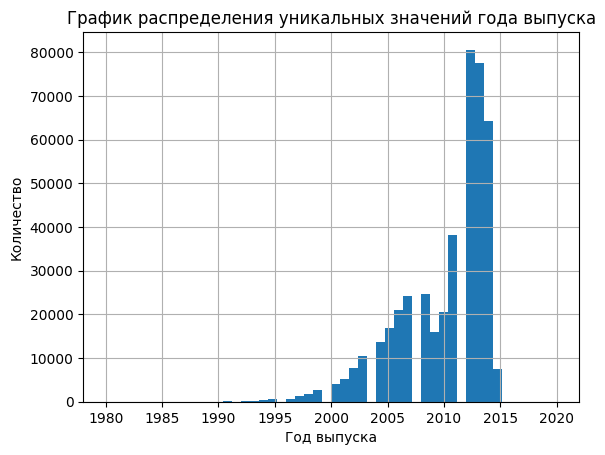

In [10]:
train['year'].hist(bins = 50,range=(1980,2020));
plt.title('График распределения уникальных значений года выпуска')
plt.ylabel('Количество')
plt.xlabel('Год выпуска')
plt.show()

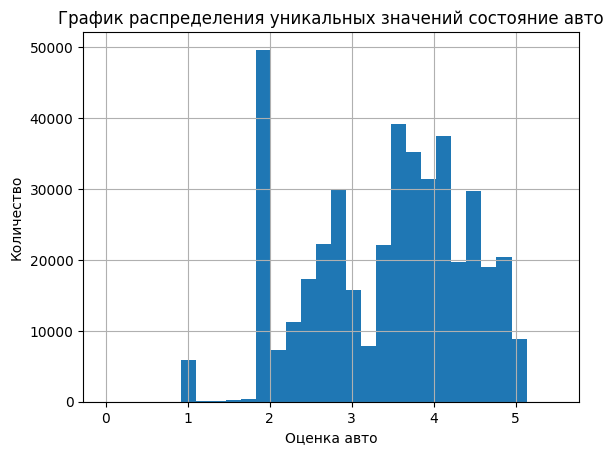

In [11]:
train['condition'].hist(bins = 30,range=(0,5.5));
plt.title('График распределения уникальных значений состояние авто')
plt.ylabel('Количество')
plt.xlabel('Оценка авто')
plt.show()

Заполним пропуски средним значением

In [12]:
train['condition'].fillna(train['condition'].mean(), inplace=True)
test['condition'].fillna(test['condition'].mean(), inplace=True)

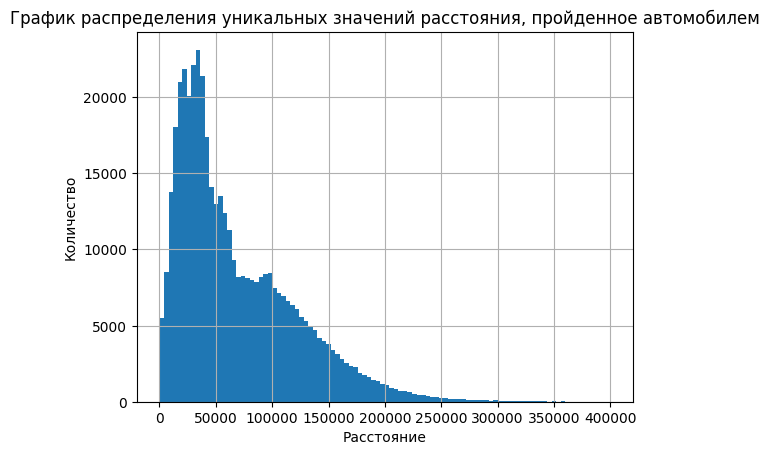

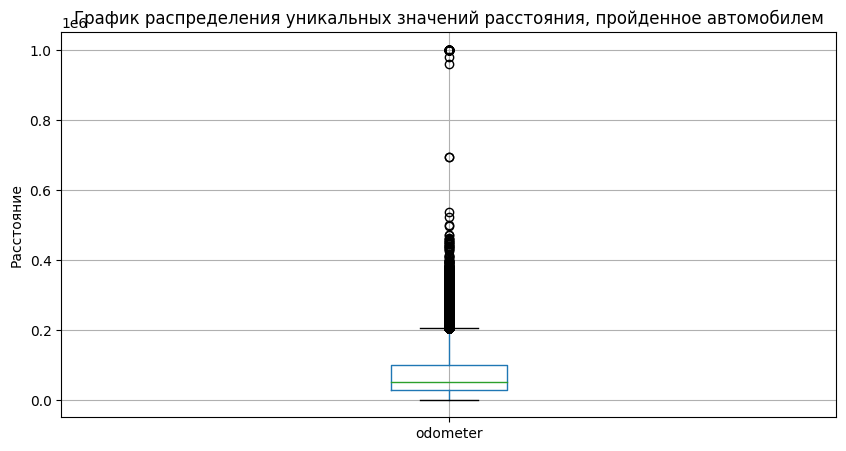

In [13]:
train['odometer'].hist(bins = 100,range=(0,400000));
plt.title('График распределения уникальных значений расстояния, пройденное автомобилем')
plt.ylabel('Количество')
plt.xlabel('Расстояние')
plt.show()

train.boxplot(['odometer'], figsize=(10,5))
plt.title('График распределения уникальных значений расстояния, пройденное автомобилем')
plt.ylabel('Расстояние')
plt.show()

Выбросы корректируем

In [14]:
train['odometer'].fillna(train['odometer'].mean(), inplace=True)
test['odometer'].fillna(test['odometer'].mean(), inplace=True)

def meter_change(value): 
    if value > 200000:
        return 250000
    else:
        return value
train["odometer"] = train["odometer"].apply(meter_change) 

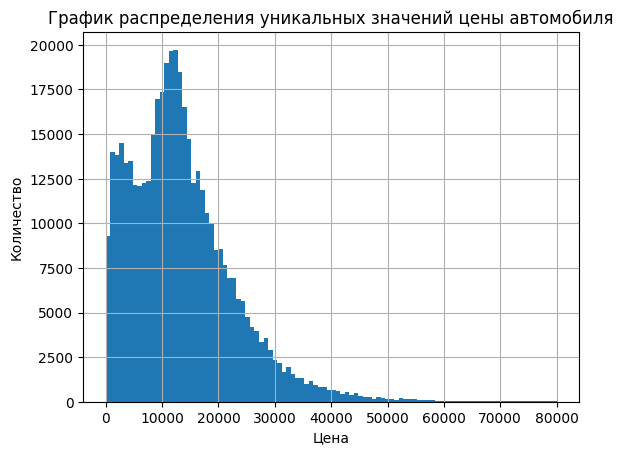

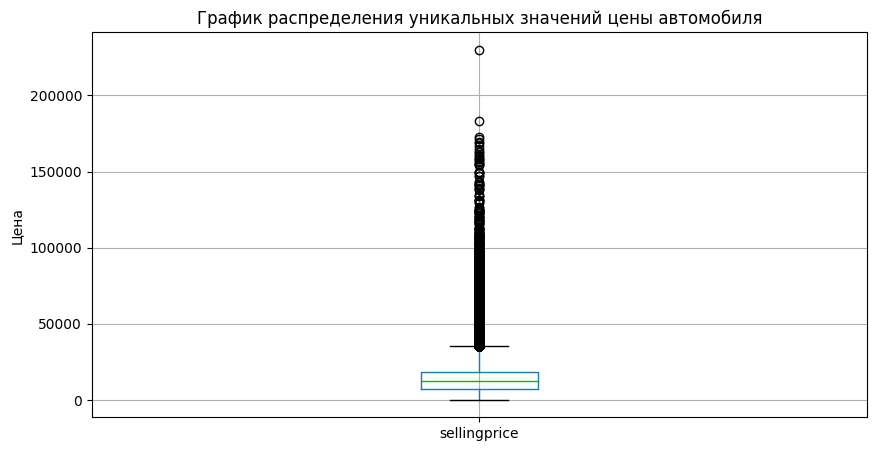

In [15]:
train['sellingprice'].hist(bins = 100,range=(0,80000));
plt.title('График распределения уникальных значений цены автомобиля')
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.show()

train.boxplot(['sellingprice'], figsize=(10,5))
plt.title('График распределения уникальных значений цены автомобиля')
plt.ylabel('Цена')
plt.show()

есть слишком дорогие авто, корректируем выбросы

In [16]:
def price_change(value): 
    if value > 42000:
        return 50000
    else:
        return value
train["sellingprice"] = train["sellingprice"].apply(price_change) 

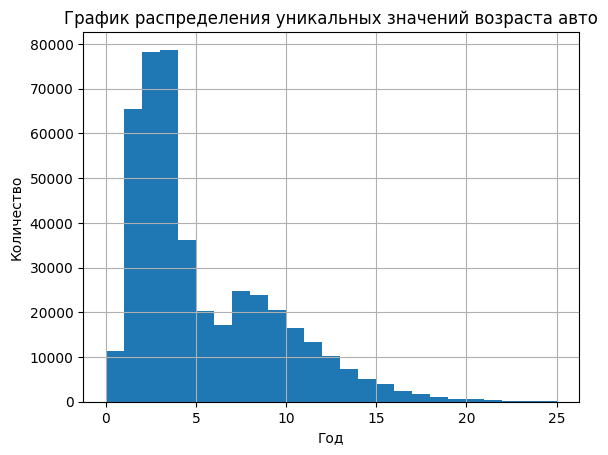

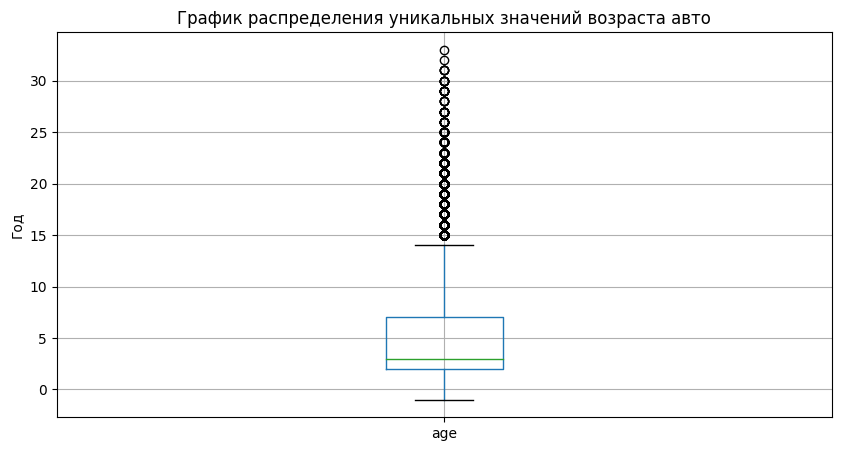

In [17]:
train['age'].hist(bins = 25,range=(0,25));
plt.title('График распределения уникальных значений возраста авто')
plt.ylabel('Количество')
plt.xlabel('Год')
plt.show()

train.boxplot(['age'], figsize=(10,5))
plt.title('График распределения уникальных значений возраста авто')
plt.ylabel('Год')
plt.show()

есть очень старые авто, приравняем их просто старым

In [18]:
def age_change(value): 
    if value > 15:
        return 15
    else:
        return value
train["age"] = train["age"].apply(age_change)

In [19]:
# немного унифицируем марки авто
train['make'] = train['make'].str.lower()
train['make'] = train['make'].replace({'mercedes-benz': 'mercedes', 
                                       'mercedes-b': 'mercedes', 
                                       'vw': 'volkswagen',
                                      'land rover':'landrover',
                                      'ford truck':'ford',
                                      'mazda tk':'mazda',
                                      'dodge tk':'dodge',
                                      'gmc truck':'gmc',
                                      'hyundai tk':'hyundai',
                                     'ford tk':'ford'})
train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai', nan,
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes', 'toyota', 'volkswagen', 'bmw', 'infiniti',
       'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus', 'scion',
       'fiat', 'suzuki', 'mazda', 'volvo', 'audi', 'mini', 'isuzu',
       'mitsubishi', 'smart', 'porsche', 'landrover', 'saturn', 'ram',
       'oldsmobile', 'mercury', 'bentley', 'fisker', 'maserati', 'tesla',
       'rolls-royce', 'ferrari', 'plymouth', 'lamborghini', 'geo',
       'aston martin', 'daewoo', 'dot', 'airstream'], dtype=object)

In [20]:
test['make'] = test['make'].str.lower()
test['make'] = test['make'].replace({'mercedes-benz': 'mercedes', 
                                       'mercedes-b': 'mercedes', 
                                       'vw': 'volkswagen',
                                      'land rover':'landrover',
                                      'ford truck':'ford',
                                      'mazda tk':'mazda',
                                      'dodge tk':'dodge',
                                      'gmc truck':'gmc',
                                      'hyundai tk':'hyundai',
                                     'ford tk':'ford'})
test['make'].unique()

array(['cadillac', 'gmc', 'nissan', 'chevrolet', 'volkswagen', 'hyundai',
       'ford', 'infiniti', 'subaru', 'kia', 'bmw', nan, 'mitsubishi',
       'dodge', 'oldsmobile', 'volvo', 'pontiac', 'acura', 'honda',
       'toyota', 'audi', 'jeep', 'lincoln', 'chrysler', 'mercedes', 'ram',
       'scion', 'mercury', 'lexus', 'saturn', 'mazda', 'porsche', 'mini',
       'smart', 'buick', 'hummer', 'jaguar', 'fiat', 'saab', 'suzuki',
       'landrover', 'geo', 'chev truck', 'bentley', 'isuzu',
       'aston martin', 'maserati', 'daewoo', 'tesla', 'ferrari', 'fisker',
       'rolls-royce', 'lotus', 'plymouth'], dtype=object)

In [21]:
train['body'] = train['body'].str.lower()
test['body'] = test['body'].str.lower()
test['body'].unique()

array(['sedan', 'van', 'suv', 'crew cab', 'wagon', 'g sedan', 'hatchback',
       'convertible', nan, 'minivan', 'coupe', 'supercrew', 'quad cab',
       'g coupe', 'crewmax cab', 'regular cab', 'g37 coupe',
       'e-series van', 'extended cab', 'supercab', 'access cab',
       'double cab', 'king cab', 'cts coupe', 'genesis coupe',
       'beetle convertible', 'promaster cargo van', 'g convertible',
       'mega cab', 'koup', 'elantra coupe', 'q60 convertible',
       'q60 coupe', 'club cab', 'cts-v coupe', 'xtracab',
       'tsx sport wagon', 'granturismo convertible', 'cab plus',
       'g37 convertible', 'regular-cab', 'transit van', 'cts wagon'],
      dtype=object)

In [22]:
train['model'] = train['model'].str.lower()
test['model'] = test['model'].str.lower()
test['model'].unique()

array(['cts', 'savana cargo', 'murano', 'impala', 'titan', 'passat',
       'sonata', 'explorer', 'g sedan', 'suburban', 'forester', 'escape',
       'fiesta', 'taurus', 'forte', '6 series', 'trailblazer',
       'silverado 1500', 'genesis', 'equinox', nan, 'lancer',
       'e-series wagon', 'grand caravan', 'focus', 'alero', 'xc60',
       'montana', 'fusion', 'soul', 'tsx', 'g6', 'accord', 'maxima',
       'camry', 'sierra 1500', 'a6', 'camaro', 'rav4', 'corolla', 'xc70',
       'compass', 'expedition', 'jetta', 'cr-v', 'ls', 'odyssey',
       'transit connect', 'optima', 'traverse', 'f-150', 'elantra',
       'altima', 's6', 'sorento', 'g35', 'm', 'fj cruiser',
       'town and country', 'civic', 'c-class', 'avenger', '1500', 'fr-s',
       'x3', '300', 'magnum', 'f-350 super duty', 'sts', 'g coupe',
       'terrain', 'spectra', 'cruze', 'journey', 'tucson', 'tundra',
       'malibu', 'grand cherokee', 'grand marquis', 'sedona', 'rx 350',
       'a4', 'ls 460', '3 series', 'x5', 'ya

Название моделей трогать не будем, вариаций очень много

In [23]:
train['trim'] = train['trim'].str.lower()
test['trim'] = test['trim'].str.lower()
train['trim'].unique()

array(['sel', 'se', '2.0 sl', ..., '2.5 x l.l.bean edition',
       '3500 high roof 140 wb', '4x4 v6 xlt sport'], dtype=object)

Так же поступим с отделкой

In [24]:
display(train[train['make'].isna()].head(5))
display(test[test['make'].isna()].head(5))

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,age
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,Thu Jan 29 2015 03:30:00 GMT-0800 (PST),8
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,Tue Jun 16 2015 02:30:00 GMT-0700 (PDT),8
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT),4
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,Thu Feb 05 2015 04:00:00 GMT-0800 (PST),7
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,Thu Feb 05 2015 04:00:00 GMT-0800 (PST),9


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,age
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.400000,143377.0,blue,gray,ryan mtrs of morristown inc,Fri Jan 23 2015 01:00:00 GMT-0800 (PST),9
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,3.423222,76674.0,black,—,effingham auto care & tire inc,Mon Dec 22 2014 11:00:00 GMT-0800 (PST),14
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.900000,107337.0,silver,gray,fairway ford henderson,Wed Feb 18 2015 02:00:00 GMT-0800 (PST),12
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.000000,243163.0,gray,—,titlemax/las vegas nv32,Thu Feb 19 2015 03:00:00 GMT-0800 (PST),17
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.100000,179884.0,white,gray,lease plan usa,Tue Feb 24 2015 01:30:00 GMT-0800 (PST),6


Есть пропуски в важных столбцах, которые мы не можем востановить

In [25]:
train[['make', 'model', 'trim', 'body']] = train[['make', 'model', 'trim', 'body']].fillna('unknown')
test[['make', 'model', 'trim', 'body']] = test[['make', 'model', 'trim', 'body']].fillna('unknown')

In [26]:
display(train['color'].unique())
display(train['interior'].unique())

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', nan, 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [27]:
# заполним пропуски
train[['color', 'interior']] = train[['color', 'interior']].fillna('—')
test[['color', 'interior']] = test[['color', 'interior']].fillna('—')

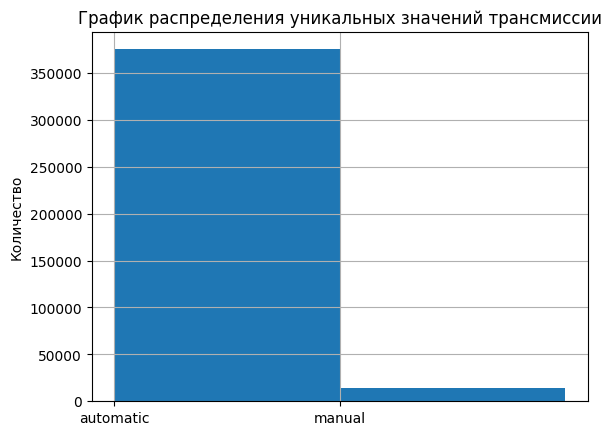

In [28]:
train['transmission'].hist(bins = 2,range=(0,2));
plt.title('График распределения уникальных значений трансмиссии')
plt.ylabel('Количество')
plt.show()

в основном машины с коробкой автомат, поэтому заполним пропуски соответствующе

In [29]:
train['transmission'].fillna('automatic', inplace=True)
test['transmission'].fillna('automatic', inplace=True)

In [30]:
# проверим наличие дубликатов по вин коду
print(train['vin'].duplicated().sum())
print(test['vin'].duplicated().sum())

0
0


In [31]:
train = train.drop(columns=['vin', 'year', 'saledate'])
test = test.drop(columns=['vin', 'year', 'saledate'])

In [32]:
# долго грузит большую матрицу
#corr_matrix = train.phik_matrix(interval_cols=['condition', 'odometer', 'sellingprice', 'age'])

#plt.figure(figsize=(15, 15))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0);

<AxesSubplot:>

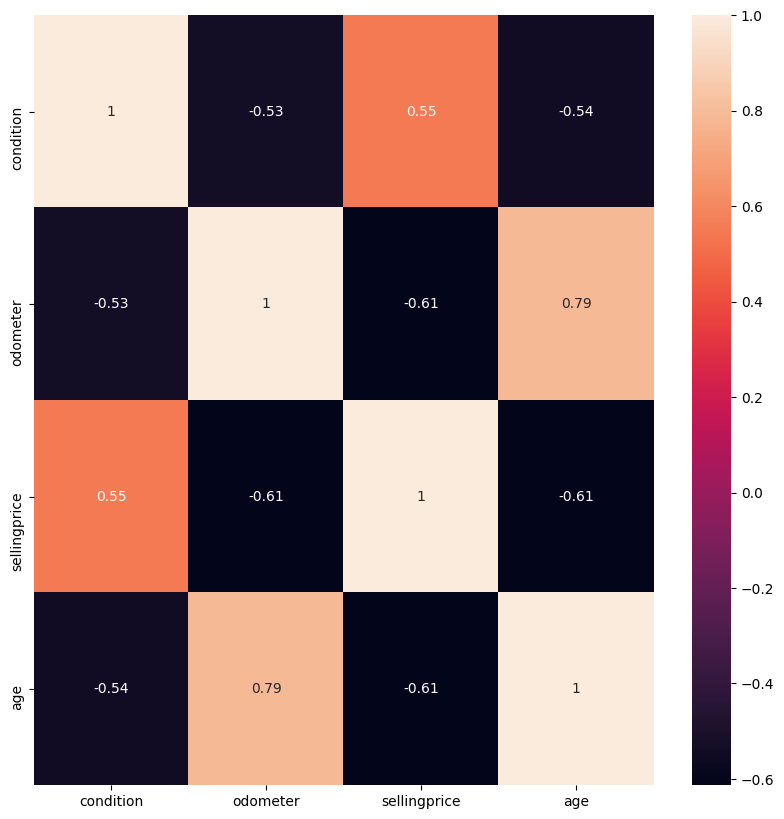

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

upp_mat = np.triu(train.corr())

mask = upp_mat

sns.heatmap(train.corr(), annot=True)

Штат и продавец слишком мало влияют на модель, удалим

In [34]:
train = train.drop(columns=['seller', 'state'])
test = test.drop(columns=['seller', 'state'])

## Обучение моделей

In [35]:
train.columns

Index(['make', 'model', 'trim', 'body', 'transmission', 'condition',
       'odometer', 'color', 'interior', 'sellingprice', 'age'],
      dtype='object')

In [36]:
#Разделим выборки
train_data, validation = train_test_split(train, random_state=RANDOM_STATE)
print(train_data.shape[0])
print(validation.shape[0])

330177
110059


In [37]:
# Подготовим категориальные признаки для catboost
cat_features = list(train_data.select_dtypes(include='object').columns)
cat_features

['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']

In [38]:
X = ['make', 'model', 'trim', 'body', 'transmission', 'condition', 'odometer', 'color',
     'interior', 'age']
y = ['sellingprice']

In [39]:
#определим гиперпараметры
param_grid = {
    'iterations': np.arange(100, 1000, 100),
    'depth': np.arange(4, 11),
}

In [40]:
params = {
    'cat_features': cat_features,
    'eval_metric': 'MAPE',
    'loss_function': 'RMSE',
    'learning_rate': 0.15,
    'random_seed': RANDOM_STATE,
    'verbose': 100
}

In [41]:
model = CatBoostRegressor(**params)

In [42]:
train_pool = Pool(data=train_data[X], 
                  label=train_data[y], 
                  cat_features=cat_features)

In [43]:
search_result = model.randomized_search(param_grid,
                                        train_pool,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8079714	test: 0.8053444	best: 0.8053444 (0)	total: 297ms	remaining: 29.4s
99:	learn: 0.3410036	test: 0.2937590	best: 0.2937590 (99)	total: 7.54s	remaining: 0us

bestTest = 0.2937589742
bestIteration = 99

0:	loss: 0.2937590	best: 0.2937590 (0)	total: 7.97s	remaining: 1m 11s
0:	learn: 0.8144648	test: 0.8110745	best: 0.8110745 (0)	total: 327ms	remaining: 1m 5s
100:	learn: 0.3108561	test: 0.2587927	best: 0.2587927 (100)	total: 23s	remaining: 22.5s
199:	learn: 0.2867382	test: 0.2336360	best: 0.2336275 (198)	total: 46.5s	remaining: 0us

bestTest = 0.2336275016
bestIteration = 198

1:	loss: 0.2336275	best: 0.2336275 (1)	total: 54.6s	remaining: 3m 38s
0:	learn: 0.8144648	test: 0.8110745	best: 0.8110745 (0)	total: 331ms	remaining: 3m 18s
100:	learn: 0.3108561	test: 0.2587927	best: 0.2587927 (100)	total: 22s	remaining: 1m 48s
200:	learn: 0.2865780	test: 0.2333721	best: 0.2333721 (200)	total: 46s	remaining: 1m 31s
300:	learn: 0.2729597	test: 0.2197315	best: 0.2197257 (298)	total: 1m 

700:	learn: 0.2138542	test: 0.1806063	best: 0.1806063 (700)	total: 4m 20s	remaining: 1m 13s
800:	learn: 0.2085368	test: 0.1793626	best: 0.1792729 (791)	total: 4m 59s	remaining: 37.1s
899:	learn: 0.2045515	test: 0.1784156	best: 0.1783785 (890)	total: 5m 39s	remaining: 0us

bestTest = 0.17837851
bestIteration = 890

Training on fold [2/3]
0:	learn: 0.8148555	test: 0.8118355	best: 0.8118355 (0)	total: 384ms	remaining: 5m 45s
100:	learn: 0.2780856	test: 0.2154176	best: 0.2154176 (100)	total: 36.4s	remaining: 4m 47s
200:	learn: 0.2531492	test: 0.1963248	best: 0.1963248 (200)	total: 1m 12s	remaining: 4m 13s
300:	learn: 0.2426617	test: 0.1881878	best: 0.1881740 (297)	total: 1m 49s	remaining: 3m 37s
400:	learn: 0.2346516	test: 0.1842164	best: 0.1842053 (398)	total: 2m 26s	remaining: 3m 1s
500:	learn: 0.2261034	test: 0.1806380	best: 0.1806380 (500)	total: 3m 5s	remaining: 2m 27s
600:	learn: 0.2210275	test: 0.1777573	best: 0.1777526 (597)	total: 3m 43s	remaining: 1m 51s
700:	learn: 0.2170590	tes

In [47]:
# создаем новую модель CatBoostRegressor с лучшими гиперпараметрами
best_model = CatBoostRegressor(loss_function='RMSE', 
                               random_seed=42, 
                               verbose=False, 
                               **best_params)

In [48]:
%%time
# обучаем модель
best_model.fit(train_pool)
print (best_model.best_score_)

{'learn': {'RMSE': 2017.1923377627886}}
CPU times: total: 29min 53s
Wall time: 8min 21s


<AxesSubplot:title={'center':'График важности признаков'}, ylabel='feature'>

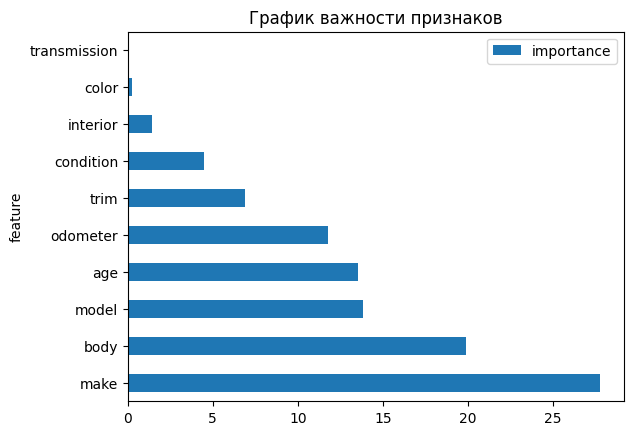

In [65]:
importances = best_model.feature_importances_
feature_list = list(test.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.plot.barh(x='feature', y='importance', title='График важности признаков')

In [50]:
validation_pool = Pool(data=validation[X], 
                  label=validation[y], 
                  cat_features=cat_features)

In [51]:
# оцениваем
y_pred = best_model.predict(validation_pool)
validation['y_pred']=y_pred 

In [53]:
rmse = mean_squared_error(validation[y], y_pred, squared=False)

# Calculate MAPE
mape = mean_absolute_percentage_error(validation[y], y_pred)

# Print the evaluation metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 2085.65
MAPE: 0.19%


Выгружаем результаты

In [54]:
y_pred_test = best_model.predict(test[X])
y_pred_test
predictions = pd.read_csv('C:/Users/Dell/Desktop/Data_YP/Cars/sample_submission.csv')

In [55]:
predictions

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588
...,...,...
110053,1j4aa2d17bl584330,13592.209588
110054,jthbf1d23e5007526,13592.209588
110055,1n4ba41e54c831950,13592.209588
110056,jn1az4eh3dm382431,13592.209588


In [58]:
test_vin = pd.read_csv('C:/Users/Dell/Desktop/Data_YP/Cars/test.csv')
test_vin['vin']

0         1g6dp567450124779
1         1gtw7fca7e1902207
2         jn8az1mw6dw303497
3         2g1wf5e34d1160703
4         1n6aa0ec3dn301209
                ...        
110053    1j4aa2d17bl584330
110054    jthbf1d23e5007526
110055    1n4ba41e54c831950
110056    jn1az4eh3dm382431
110057    2g1fa1e32c9193058
Name: vin, Length: 110058, dtype: object

In [59]:
prediction = predictions
prediction['vin']=test_vin['vin']
prediction.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [60]:
prediction['sellingprice']=y_pred_test
prediction

,vin,sellingprice
0,1g6dp567450124779,4603.673762
1,1gtw7fca7e1902207,19780.279121
2,jn8az1mw6dw303497,20618.248702
3,2g1wf5e34d1160703,8566.918947
4,1n6aa0ec3dn301209,21380.349932
...,...,...
110053,1j4aa2d17bl584330,17273.011194
110054,jthbf1d23e5007526,30049.651552
110055,1n4ba41e54c831950,3505.518691
110056,jn1az4eh3dm382431,18314.094221


In [61]:
prediction.to_csv('results.csv', index=False)